# Exploratory Data Analysis – `Label.csv`
# 1.Introduction

**Mục tiêu**  
- Hiểu nhanh cấu trúc và chất lượng dữ liệu nhãn (`STT`, `VIDEO`, `TEXT`) thu thập từ trang QIPEDC.  
- Xác định mức độ cân bằng nhãn, độ dài từ/cụm, sự phổ biến của các cụm “thường ngày”.  
- Nghĩ ra các bước tiền xử lý/phân mẫu phù hợp (train / test split, loại bỏ ngoại lệ, v.v.) trước khi huấn luyện mô hình nhận diện Ngôn ngữ Ký hiệu Việt Nam.

> **Tóm tắt dữ liệu gốc**  
> * `Label.csv` – toàn bộ 4 000+ video, mỗi dòng chứa:  
>   * `STT` — số thứ tự  
>   * `VIDEO` — tên file `.mp4`  
>   * `TEXT` — từ/cụm nghĩa tiếng Việt


In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### 2. Đọc file gốc và kiểm tra kích thước tập dữ liệu
* Hiển thị 5 dòng đầu để đảm bảo đọc đúng cột và encoding.
* In `shape` để biết có bao nhiêu video/nhãn.


In [2]:
#  Đọc file gốc
df = pd.read_csv('Dataset/Text/Label.csv')


In [3]:
df.columns

Index(['STT', 'VIDEO', 'TEXT'], dtype='object')

In [4]:
# Xem dữ liệu đầu tiên
df.head()


,STT,VIDEO,TEXT
0,1,D0006.mp4,Ma Cao
1,2,D0001N.mp4,địa chỉ
2,3,D0011.mp4,Đu Bai (nước Đu Bai)
3,4,D0009.mp4,phương Tây
4,5,D0005B.mp4,Miến Điện (nước Mi-an-ma)


In [5]:
# Đổi cột index thành cột STT
df = pd.read_csv('Dataset/Text/Label.csv' ,index_col='STT')


### 3. Kiểm tra giá trị thiếu và trùng lặp
* Xác định xem có bản ghi nào thiếu cột `TEXT` hoặc `VIDEO`.  
* Loại bỏ trùng lặp nếu có (`STT` lặp lại hoặc cùng tên video).


In [6]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 1 to 4362
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   VIDEO   4362 non-null   object
 1   TEXT    4362 non-null   object
dtypes: object(2)
memory usage: 102.2+ KB


In [7]:
# Xem số lượng các nhãn
df.describe()

,VIDEO,TEXT
count,4362,4362
unique,4362,3315
top,D0006.mp4,thương yêu
freq,1,6


### 4. Thống kê tần suất xuất hiện của mỗi nhãn (`TEXT`)
* Mục tiêu: xem nhãn cân bằng tới mức nào; phát hiện nhãn hiếm.  
* Kết quả được lưu trong biến `freq` để dùng về sau.


In [8]:
# Hiển thị tất cả các nhãn có số lần xuất hiện > 1 
label_counts = df['TEXT'].value_counts()
labels_gt1 = label_counts[label_counts > 1]
print("Các nhãn có số lần xuất hiện > 1:")
print(labels_gt1)

Các nhãn có số lần xuất hiện > 1:
TEXT
thương yêu      6
đặc biệt        4
thành lập       4
thường xuyên    4
tưởng tượng     4
               ..
chơi            2
điều phối       2
sơ đồ           2
khó khăn        2
quả điều        2
Name: count, Length: 550, dtype: int64


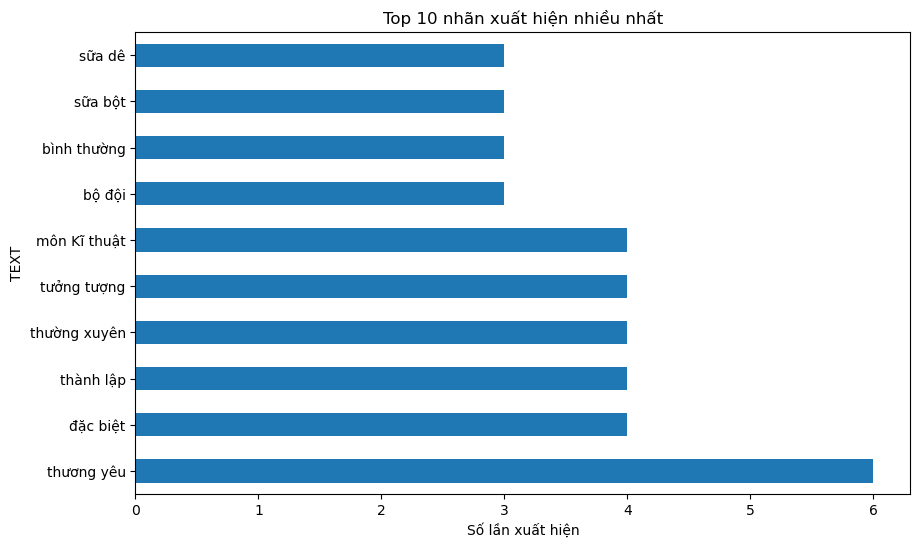

In [9]:
# Top 10 nhãn xuất hiện nhiều nhất
plt.figure(figsize=(10, 6))
df['TEXT'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 nhãn xuất hiện nhiều nhất')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('TEXT')
plt.show()

### 5. Xây dựng hàm `is_everyday()`  
Lọc bỏ:
* nhãn quá ngắn (≤ 1 ký tự)  
* nhãn chứa số/ngoặc, địa danh, từ chuyên ngành  
* cụm > 4 từ (quá dài, ít dùng trong hội thoại ngắn)  
→ Giữ lại các cụm giao tiếp phổ biến.

Giải thích nhanh về bộ lọc

| Tiêu chí                         | Mục đích                                          |
| -------------------------------- | ------------------------------------------------- |
| **Không ngoặc, không số**        | Loại cụm chứa *ghi chú* (nước …) hoặc mã          |
| **Không “nước/tỉnh/…”**          | Tránh địa danh – ít dùng trong câu ngắn hằng ngày |
| **Không > 4 từ**                 | Giữ cụm gọn, dễ đệm vào hội thoại                 |
| **Không thuật ngữ “kĩ thuật/…”** | Loại khái niệm chuyên ngành                       |


In [10]:

# ---------- 2) Đếm tần suất từng nhãn ----------
freq = df['TEXT'].value_counts()      # Series: TEXT -> COUNT

# ---------- 3) Hàm đánh giá "tính hội thoại" ----------
def is_everyday(text: str) -> bool:
    t = text.strip()

    # bỏ cụm ngắn hoặc 1 ký tự
    if len(t) <= 1:
        return False
    # bỏ mục có ngoặc, chữ-số
    if '(' in t or ')' in t or re.search(r'\d', t):
        return False
    # bỏ tên quốc gia / địa danh
    if any(word in t.lower()
           for word in ['nước', 'tỉnh', 'thành phố', 'quốc gia']):
        return False
    # bỏ cụm chuyên ngành
    if any(word in t.lower()
           for word in ['kĩ thuật', 'khoa học', 'công nghiệp']):
        return False
    # bỏ chuỗi > 4 từ (quá dài, ít dùng thành “từ đơn”)
    if len(t.split()) > 4:
        return False
    return True


### 6. Lấy 50 nhãn thỏa điều kiện  
* Chỉ giữ nhãn xuất hiện ≥ 2 lần (`candidates`)  
* Áp dụng bộ lọc “everyday” → `top50`  
* Thêm cột `STT` (1 → 50) để tiện quan sát.


In [ ]:

# ---------- Lọc & lấy Top-50 ----------
candidates = freq[freq > 1]                      
everyday   = candidates[candidates.index.map(is_everyday)]

top50 = (
    everyday.head(50)            
           .reset_index()        
)

# Đặt lại tên cột cho rõ ràng
top50.columns = ['TEXT', 'COUNT']  

# ---------- Thêm cột STT ----------
top50.insert(0, 'STT', range(1, len(top50) + 1))   

print(top50.to_string(index=False))


 STT              TEXT  COUNT
   1        thương yêu      6
   2          đặc biệt      4
   3         thành lập      4
   4      thường xuyên      4
   5       tưởng tượng      4
   6            bộ đội      3
   7       bình thường      3
   8           sữa bột      3
   9            sữa dê      3
  10            sữa bò      3
  11          bón phân      3
  12             sơ mi      3
  13          bố dượng      3
  14        cây cổ thụ      3
  15          bông hoa      3
  16           sữa hộp      3
  17          sinh sản      3
  18      bốt cảnh sát      3
  19           bột màu      3
  20          bốt điện      3
  21           sinh đẻ      3
  22                cỏ      3
  23               sữa      3
  24          tái phạm      3
  25           bình an      3
  26           tha thứ      3
  27          thăm hỏi      3
  28 bảo vệ môi trường      3
  29         tham quan      3
  30             tháng      3
  31           tham dự      3
  32           thái độ      3
  33      

### 7. Thống kê mô tả và lưu danh sách Top-50  
* Hiển thị `describe()` cho cột `COUNT`.  
* Tính độ dài chuỗi (`WORD_LEN`) và độ dài *trung bình*.  
* Lưu file `Dataset/Text/top50_daily.csv` để dùng lại.


In [12]:
# ---------- Hiển thị & lưu ----------

top50.to_csv('Dataset/Text/top50_daily.csv',
             index=False, encoding='utf-8')
print('\n✅ Đã ghi file Dataset/Text/top50_daily.csv')
    


✅ Đã ghi file Dataset/Text/top50_daily.csv


In [ ]:
# ---------- Thống kê độ dài từ ----------
top50['WORD_LEN'] = top50['TEXT'].str.len()

summary = top50['COUNT'].describe()
print('\n=== SUMMARY COUNT ===')
print(summary)
print('\nTổng số mục   :', len(top50))
print('Độ dài TB (ký tự):', round(top50['WORD_LEN'].mean(), 2))


=== SUMMARY COUNT ===
count    50.000000
mean      3.140000
std       0.495284
min       3.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       6.000000
Name: COUNT, dtype: float64

Tổng số mục   : 50
Độ dài TB (ký tự): 7.8


### 8. Histogram – Phân bố tần suất xuất hiện  
Biểu đồ cho thấy bao nhiêu nhãn xuất hiện 3, 4, 5 … lần.  
Điều này giúp đánh giá độ cân bằng của bộ nhãn Top-50.


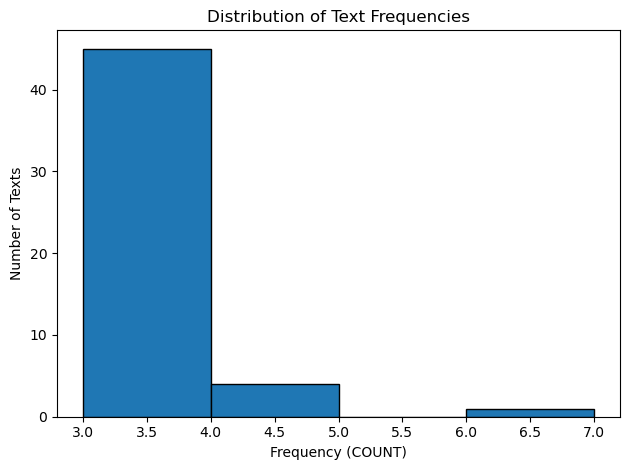

In [14]:
plt.figure()
plt.hist(top50['COUNT'],
         bins=range(int(top50['COUNT'].min()),
                    int(top50['COUNT'].max()) + 2),
         edgecolor='black')
plt.title('Distribution of Text Frequencies')
plt.xlabel('Frequency (COUNT)')
plt.ylabel('Number of Texts')
plt.tight_layout()

### 9. Histogram – Phân bố độ dài ký tự  
Mục tiêu: kiểm tra tính “ngắn gọn” của nhãn.  
Đa số rơi vào 6–9 ký tự; quá dài/ quá ngắn là ngoại lệ.


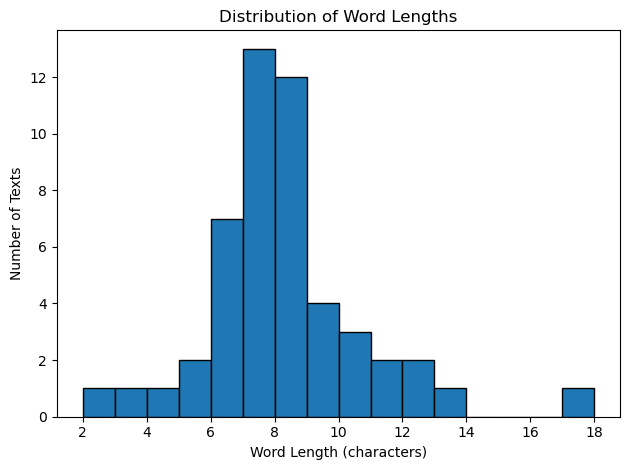

In [15]:
plt.figure()
plt.hist(top50['WORD_LEN'],
         bins=range(int(top50['WORD_LEN'].min()),
                    int(top50['WORD_LEN'].max()) + 2),
         edgecolor='black')
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length (characters)')
plt.ylabel('Number of Texts')
plt.tight_layout()